# Data Bootcamp Final Project

## Predicting S&P 500 Stock Outperformance vs SPY (12‑month horizon)

Kashish Hundia and John Zhang

---

### Introduction

In this project, we use financial data from S&P 500 companies to build a predictive model that estimates whether a stock will outperform the overall market (measured by **SPY**) over the following **12 months**.

The dataset includes firm-level indicators like valuation ratios, profitability measures, leverage metrics, and risk indicators. We treat this as a **binary classification** task: the target is **1** if a stock’s forward 12‑month return beats SPY’s forward 12‑month return, otherwise **0**.

We compare several supervised learning models and interpret the results using both performance metrics (accuracy / F1 / ROC‑AUC) and feature importance.


### Data Description

We use two main data sources:

- A list of S&P 500 tickers from Wikipedia (downloaded once and cached locally).
- Firm fundamentals + price history from `yfinance`.

The features include things like P/E, price-to-book, margins, ROE/ROA, debt, cash, and beta. We also create a few simple ratios (ex: debt-to-market-cap) to make comparisons across firms easier.

> Note: `yfinance` fundamentals are a snapshot from when you pull them, so they may not perfectly line up with the “as-of” date used for returns. I mention this again in the limitations at the end.


## 0. Setup

In [39]:
import warnings
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import yfinance as yf
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

warnings.filterwarnings("ignore")
RANDOM_STATE = 42


## 1. Small helpers (saving + caching)

We are caching downloads because pulling 500 tickers + fundamentals + prices can be slow. If the cache exists, the notebook loads it instead of downloading again.

In [40]:
CACHE_DIR = Path("../data/cache")
OUT_DIR   = Path("../data/processed")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

def cache_path(name: str) -> Path:
    return CACHE_DIR / name

def save_df(df: pd.DataFrame, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)

def load_df(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)

def winsorize_series(s: pd.Series, lower_q=0.01, upper_q=0.99):
    # clips extreme outliers so plots/models don’t get dominated by a few crazy values
    lo = s.quantile(lower_q)
    hi = s.quantile(upper_q)
    return s.clip(lower=lo, upper=hi)


## 2. Pull S&P 500 tickers (Wikipedia)

Some environments block Wikipedia. This uses a browser-like header + saves the table to cache.

In [41]:
WIKI_URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tickers_cache = cache_path("sp500_tickers.csv")

def get_sp500_table():
    # 1) try cache first
    if tickers_cache.exists():
        return load_df(tickers_cache)

    # 2) fetch with a User-Agent to avoid 403 error
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X) AppleWebKit/537.36 (KHTML, like Gecko) Chrome Safari"
    }
    r = requests.get(WIKI_URL, headers=headers, timeout=30)
    r.raise_for_status()

    tables = pd.read_html(r.text)
    sp500 = tables[0].copy()
    save_df(sp500, tickers_cache)
    return sp500

sp500 = get_sp500_table()
sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


## 3. Pull fundamentals from yfinance

Grabbing a handful of common financial indicators for each ticker

In [42]:
import time
N_TICKERS = 500
tickers = sp500["Symbol"].head(N_TICKERS).tolist()

# yfinance uses '-' instead of '.' for its tickers
tickers = [t.replace(".", "-") for t in tickers]

fund_cache = cache_path(f"fundamentals_{N_TICKERS}.csv")

def fetch_fundamentals(tickers):
    rows = []
    for i, t in enumerate(tickers, 1):
        try:
            info = yf.Ticker(t).info
            rows.append({
                "ticker": t,
                "shortName": info.get("shortName"),
                "sector": info.get("sector"),
                "industry": info.get("industry"),
                "marketCap": info.get("marketCap"),
                "enterpriseValue": info.get("enterpriseValue"),
                "trailingPE": info.get("trailingPE"),
                "forwardPE": info.get("forwardPE"),
                "priceToBook": info.get("priceToBook"),
                "beta": info.get("beta"),
                "dividendYield": info.get("dividendYield"),
                "profitMargins": info.get("profitMargins"),
                "operatingMargins": info.get("operatingMargins"),
                "returnOnAssets": info.get("returnOnAssets"),
                "returnOnEquity": info.get("returnOnEquity"),
                "revenueGrowth": info.get("revenueGrowth"),
                "earningsGrowth": info.get("earningsGrowth"),
                "totalRevenue": info.get("totalRevenue"),
                "grossProfits": info.get("grossProfits"),
                "ebitda": info.get("ebitda"),
                "totalCash": info.get("totalCash"),
                "totalDebt": info.get("totalDebt"),
                "freeCashflow": info.get("freeCashflow"),
                "currentPrice": info.get("currentPrice"),
                "sharesOutstanding": info.get("sharesOutstanding"),
            })
        except Exception:
            rows.append({"ticker": t})
        if i % 25 == 0:
            time.sleep(0.4)  # light throttle
    return pd.DataFrame(rows)

if fund_cache.exists():
    fundamentals = load_df(fund_cache)
else:
    fundamentals = fetch_fundamentals(tickers)
    save_df(fundamentals, fund_cache)

fundamentals.shape, fundamentals.head()


((500, 25),
   ticker               shortName       sector  \
 0    MMM              3M Company  Industrials   
 1    AOS  A.O. Smith Corporation  Industrials   
 2    ABT     Abbott Laboratories   Healthcare   
 3   ABBV             AbbVie Inc.   Healthcare   
 4    ACN           Accenture plc   Technology   
 
                           industry     marketCap  enterpriseValue  trailingPE  \
 0                    Conglomerates   86158180352     9.397427e+10   25.757960   
 1   Specialty Industrial Machinery    9555436544     9.537365e+09   18.380054   
 2                  Medical Devices  217766232064     2.230066e+11   15.718594   
 3     Drug Manufacturers - General  393808642048     4.580194e+11  168.803020   
 4  Information Technology Services  178268864512     1.675005e+11   22.218930   
 
    forwardPE  priceToBook   beta  ...  revenueGrowth  earningsGrowth  \
 0  18.713017    18.567493  1.148  ...          0.035          -0.375   
 1  16.528145     5.147581  1.335  ...        

## 4. Cleaning + feature engineering

I’m adding a few simple ratios (debt/market cap, cash/market cap, etc.). Then I clip extreme values a bit so the model isn’t overwhelmed by outliers.

In [43]:
df = fundamentals.copy()

df["debt_to_mktcap"] = df["totalDebt"] / df["marketCap"]
df["cash_to_mktcap"] = df["totalCash"] / df["marketCap"]
df["ev_to_mktcap"]   = df["enterpriseValue"] / df["marketCap"]
df["fcf_to_mktcap"]  = df["freeCashflow"] / df["marketCap"]

# keep only rows with the basics
df = df.dropna(subset=["marketCap", "sector"]).reset_index(drop=True)

# winsorize numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
for c in num_cols:
    df[c] = winsorize_series(df[c])

df.describe(include="all").T.head(15)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ticker,499,499,YUM,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shortName,499,496,Alphabet Inc.,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sector,499,11,Technology,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
industry,499,111,Utilities - Regulated Electric,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marketCap,499.0,NaN,NaN,NaN,116566922898.417435,306681513306.993896,8035281274.88,20596280320.0,38811205632.0,86380691456.0,2447581013606.378418
enterpriseValue,495.0,NaN,NaN,NaN,122179290757.999207,302241642866.748291,7444531194.880001,24790884352.0,47224782848.0,101363146752.0,2501494167306.242676
trailingPE,472.0,NaN,NaN,NaN,35.66652,44.9613,7.526076,17.933432,25.111411,34.466195,361.9174
forwardPE,499.0,NaN,NaN,NaN,21.576218,13.766235,5.891674,13.036606,18.564299,25.334739,93.67939
priceToBook,499.0,NaN,NaN,NaN,4.124755,18.12201,-105.424777,1.753069,3.103713,7.051858,67.278021
beta,493.0,NaN,NaN,NaN,0.979086,0.419509,0.1236,0.673,0.994,1.253,2.29592


## Models and Methods

### Target definition (what we predict)

We label each stock based on whether it beats SPY over the next ~252 trading days (about a year).

- Target = 1 if stock forward return > SPY forward return
- Target = 0 otherwise


## 5. Download prices and build the target label

In [44]:

ASOF_DATE = None
FWD_DAYS = 252     # this equals approximately 12 months of trading days

prices_cache = cache_path(f"prices_{N_TICKERS}_fwd{FWD_DAYS}.pkl")

def fetch_prices(tickers, fwd_days=252, asof_date=None):
    end = None
    if asof_date is None:
        start = (datetime.today() - timedelta(days=900)).strftime("%Y-%m-%d")
    else:
        asof = datetime.strptime(asof_date, "%Y-%m-%d")
        start = (asof - timedelta(days=30)).strftime("%Y-%m-%d")
        end   = (asof + timedelta(days=int(fwd_days*1.8))).strftime("%Y-%m-%d")
    px = yf.download(tickers + ["SPY"], start=start, end=end, auto_adjust=True, progress=False)["Close"]
    return px

if prices_cache.exists():
    prices = joblib.load(prices_cache)
else:
    prices = fetch_prices(tickers, fwd_days=FWD_DAYS, asof_date=ASOF_DATE)
    joblib.dump(prices, prices_cache)

prices.tail()


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WSM,WST,WTW,WY,WYNN,XEL,XOM,XYL,XYZ,YUM
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-12,NaN,278.279999,223.320007,128.389999,125.459999,NaN,NaN,356.429993,279.320007,60.009998,...,NaN,NaN,NaN,23.389999,123.660004,75.150002,118.820000,137.100006,64.750000,151.059998
2025-12-15,140.600006,274.109985,227.449997,131.809998,128.470001,95.720001,274.660004,351.149994,280.440002,60.200001,...,185.429993,271.859985,330.769989,23.350000,126.250000,75.720001,117.760002,138.250000,64.019997,153.820007
2025-12-16,139.190002,274.609985,223.669998,132.009995,126.860001,95.580002,272.040009,347.890015,278.399994,57.980000,...,185.509995,266.440002,329.760010,23.280001,126.040001,73.730003,114.680000,137.600006,64.550003,151.029999
2025-12-17,136.660004,271.839996,224.309998,133.779999,126.709999,95.889999,273.739990,354.660004,271.040009,58.560001,...,185.690002,269.130005,329.839996,23.730000,125.440002,73.139999,117.410004,136.880005,63.770000,153.139999
2025-12-18,136.899994,272.190002,222.820007,133.990005,125.120003,96.449997,269.959991,355.809998,274.920013,58.299999,...,189.360001,268.660004,329.649994,23.600000,126.510002,73.610001,116.540001,136.690002,64.389999,154.699997


In [45]:

px = prices.dropna(how="all")

# pick an as-of date that still allows a full forward window
if ASOF_DATE is None:
    asof_dt = px.index[-(FWD_DAYS + 5)]
else:
    target_dt = pd.to_datetime(ASOF_DATE)
    asof_dt = px.index[px.index.get_indexer([target_dt], method="backfill")][0]

asof_dt


Timestamp('2024-12-10 00:00:00')

In [46]:

asof_prices = px.loc[asof_dt]
fwd_dt = px.index[px.index.get_loc(asof_dt) + FWD_DAYS]
fwd_prices = px.loc[fwd_dt]

stock_fwd = (fwd_prices[tickers] - asof_prices[tickers]) / asof_prices[tickers]
spy_fwd   = (fwd_prices["SPY"] - asof_prices["SPY"]) / asof_prices["SPY"]

target = (stock_fwd > spy_fwd).astype(int).rename("outperform_spy_12m")
target.head(), float(spy_fwd)


(Ticker
 MMM     1
 AOS     0
 ABT     0
 ABBV    1
 ACN     0
 Name: outperform_spy_12m, dtype: int64,
 0.14473880278091664)

## 6. Merge features + target

Now we combine the fundamentals table with the label we just created. Also, we convert `sector` into dummy variables so models can use it.

In [47]:

# just in case ticker got renamed earlier
if "ticker" not in df.columns:
    if "Symbol" in df.columns:
        df = df.rename(columns={"Symbol": "ticker"})
    else:
        df = df.reset_index().rename(columns={"index": "ticker"})

target_df = target.reset_index()
if "ticker" not in target_df.columns:
    target_df = target_df.rename(columns={target_df.columns[0]: "ticker"})

model_df = df.merge(target_df, on="ticker", how="inner")

# one-hot encode sector
model_df = pd.get_dummies(model_df, columns=["sector"], drop_first=True)

processed_path = OUT_DIR / "modeling_dataset.csv"
save_df(model_df, processed_path)

model_df.shape, model_df.head()


((499, 39),
   ticker               shortName                         industry  \
 0    MMM              3M Company                    Conglomerates   
 1    AOS  A.O. Smith Corporation   Specialty Industrial Machinery   
 2    ABT     Abbott Laboratories                  Medical Devices   
 3   ABBV             AbbVie Inc.     Drug Manufacturers - General   
 4    ACN           Accenture plc  Information Technology Services   
 
       marketCap  enterpriseValue  trailingPE  forwardPE  priceToBook   beta  \
 0  8.615818e+10     9.397427e+10   25.757960  18.713017    18.567493  1.148   
 1  9.555437e+09     9.537365e+09   18.380054  16.528145     5.147581  1.335   
 2  2.177662e+11     2.230066e+11   15.718594  22.045286     4.269870  0.714   
 3  3.938086e+11     4.580194e+11  168.803020  15.633595  -105.424777  0.349   
 4  1.782689e+11     1.675005e+11   22.218930  18.162064     5.381441  1.261   
 
    dividendYield  ...  sector_Communication Services  \
 0           1.80  ...     

## 7. Quick EDA

This is just to sanity-check: class balance and a few feature comparisons by class.

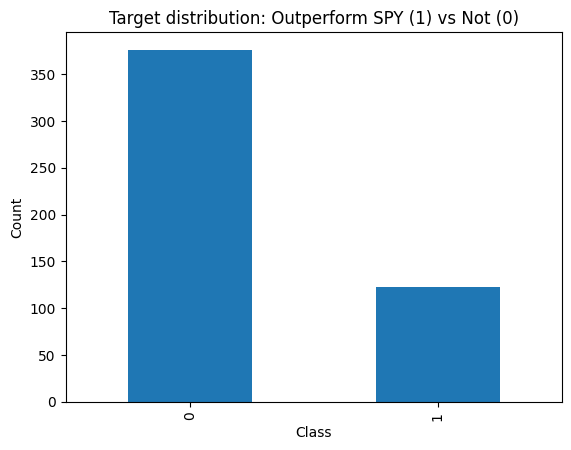

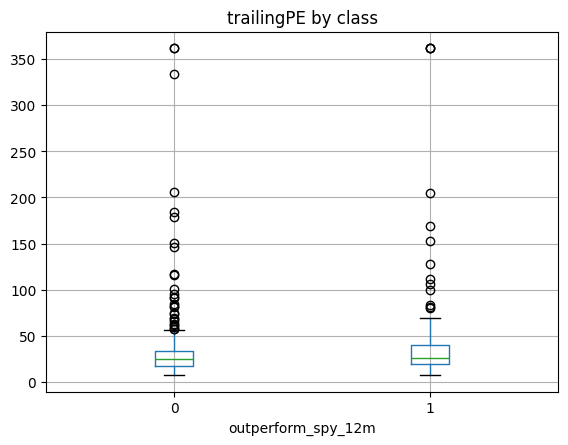

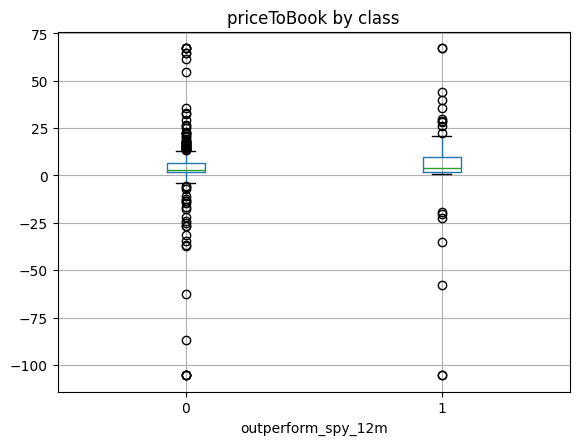

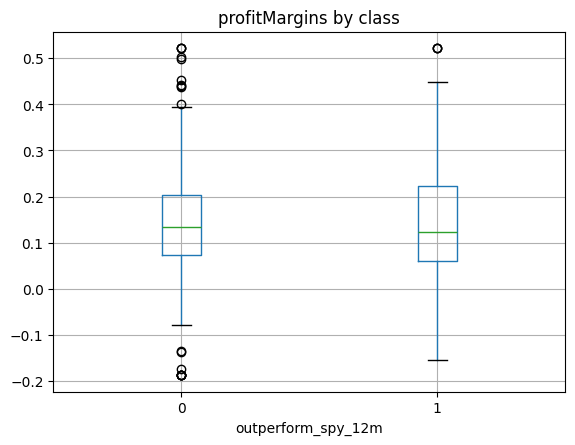

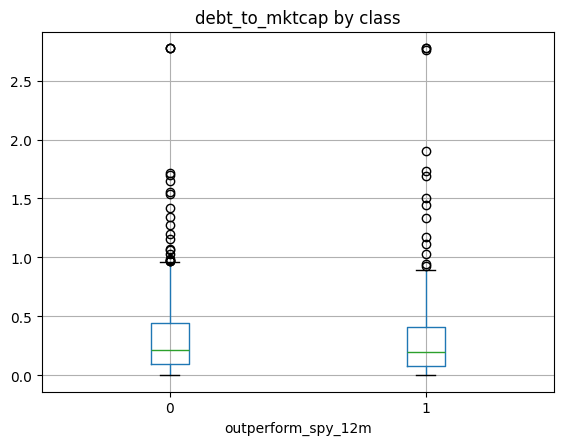

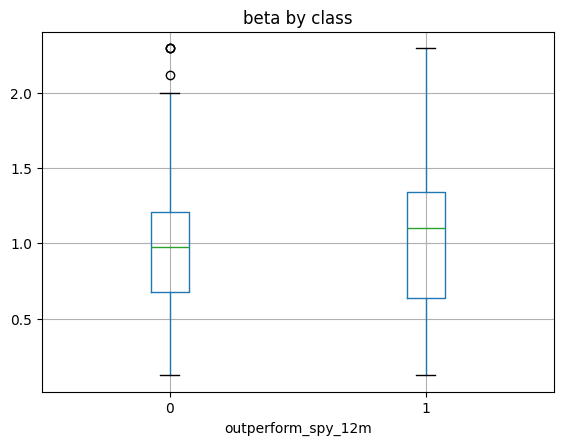

In [48]:

counts = model_df["outperform_spy_12m"].value_counts().sort_index()
counts.plot(kind="bar")
plt.title("Target distribution: Outperform SPY (1) vs Not (0)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

for col in ["trailingPE", "priceToBook", "profitMargins", "debt_to_mktcap", "beta"]:
    if col in model_df.columns:
        model_df.boxplot(column=col, by="outperform_spy_12m")
        plt.title(f"{col} by class")
        plt.suptitle("")
        plt.xlabel("outperform_spy_12m")
        plt.show()


## 8. Train/test split + model training

We split into train/test sets, then try several models. For scaling and missing values, I use a Pipeline so it’s done consistently.

In [49]:

y = model_df["outperform_spy_12m"].astype(int)

X = model_df.drop(columns=[
    "outperform_spy_12m",
    "ticker", "shortName", "industry"
], errors="ignore")

# convert bool dummies to 0/1
for col in X.columns:
    if X[col].dtype == "bool":
        X[col] = X[col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape


((374, 35), (125, 35))

In [50]:

logreg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
])

knn = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=15))
])

tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(max_depth=6, random_state=RANDOM_STATE))
])

rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=400, min_samples_leaf=2,
        random_state=RANDOM_STATE, n_jobs=-1
    ))
])

gb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

models = {
    "LogReg": logreg,
    "KNN": knn,
    "DecisionTree": tree,
    "RandomForest": rf,
    "GradientBoosting": gb
}

def eval_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    out = {
        "model": name,
        "accuracy": accuracy_score(y_test, pred),
        "precision": precision_score(y_test, pred, zero_division=0),
        "recall": recall_score(y_test, pred, zero_division=0),
        "f1": f1_score(y_test, pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, proba) if proba is not None else np.nan
    }
    return out, pred, proba, model

results = []
pred_store = {}

for name, model in models.items():
    m, pred, proba, fitted = eval_model(name, model, X_train, y_train, X_test, y_test)
    results.append(m)
    pred_store[name] = {"pred": pred, "proba": proba, "model": fitted}

results_df = pd.DataFrame(results).sort_values(by=["roc_auc", "f1"], ascending=False)
results_df


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg,0.744,0.461538,0.193548,0.272727,0.747769
4,GradientBoosting,0.776,0.666667,0.193548,0.300000,0.726150
3,RandomForest,0.768,0.625000,0.161290,0.256410,0.701441
2,DecisionTree,0.768,0.625000,0.161290,0.256410,0.642931
1,KNN,0.768,0.666667,0.129032,0.216216,0.619252


# Results
Among the models tested, Logistic Regression and Gradient Boosting perform the best overall. Logistic Regression has the highest ROC-AUC (around 0.75), suggesting it does a better job distinguishing between stocks that outperform SPY and those that do not. Gradient Boosting achieves the highest accuracy and F1 score, indicating a better balance between precision and recall.

Across all models, recall is relatively low, which shows that correctly identifying stocks that beat the market is challenging. This is expected since outperforming SPY is less common and the dataset is imbalanced. Because of this, accuracy alone is not very informative, and metrics like F1 score and ROC-AUC provide a clearer picture of model performance.

Overall, the results suggest that financial fundamentals contain some predictive signal, but predicting market outperformance remains difficult.

## 9. Best model diagnostics

Best model: LogReg
model          LogReg
accuracy        0.744
precision    0.461538
recall       0.193548
f1           0.272727
roc_auc      0.747769
Name: 0, dtype: object


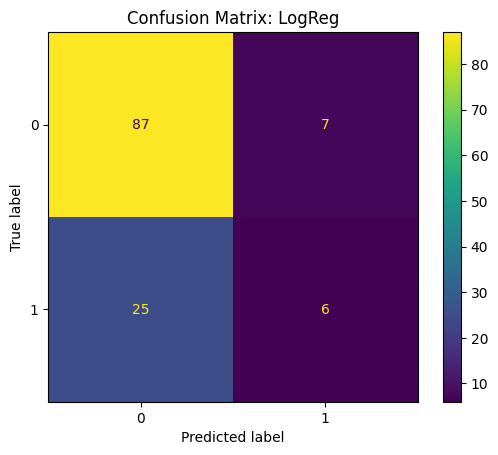

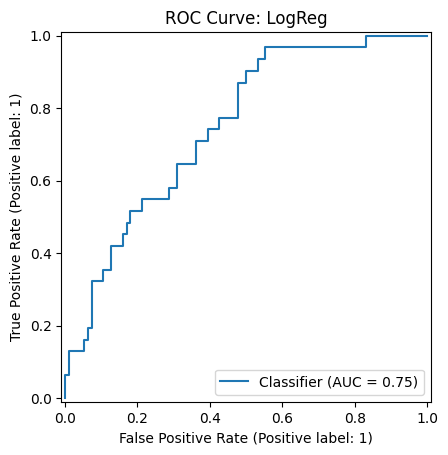

In [51]:

best_name = results_df.iloc[0]["model"]
best = pred_store[best_name]

print("Best model:", best_name)
print(results_df.iloc[0])

cm = confusion_matrix(y_test, best["pred"])
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix: {best_name}")
plt.show()

if best["proba"] is not None:
    RocCurveDisplay.from_predictions(y_test, best["proba"])
    plt.title(f"ROC Curve: {best_name}")
    plt.show()


# Model Diagnostics

The confusion matrix shows that the Logistic Regression model correctly classifies most stocks that do not outperform SPY. Out of the test set, 87 underperforming stocks are correctly predicted, while only 7 are incorrectly classified as outperformers. This indicates that the model is relatively conservative and avoids falsely predicting outperformance.

However, the model struggles to identify stocks that actually outperform the market. Only 6 outperforming stocks are correctly predicted, while 25 are missed and classified as underperformers. This explains the relatively low recall value and reflects the difficulty of predicting market outperformance using firm fundamentals alone.

The ROC curve further supports this interpretation. With a ROC-AUC of approximately 0.75, the model performs meaningfully better than random guessing, indicating that it can rank stocks by their likelihood of outperforming SPY even if it does not perfectly classify them at a single threshold.

Overall, the diagnostics suggest that while the model is cautious and better at ruling out underperformers, it still captures useful predictive signal when evaluated across different classification thresholds.

## 10. Interpretation (what features mattered?)

For tree/forest/boosting models, we can look at **feature importance**. For logistic regression, we can look at **coefficients**.

,0
grossProfits,-1.114981
ebitda,-1.042382
totalDebt,0.779692
dividendYield,-0.724273
enterpriseValue,0.665391
totalRevenue,0.581559
freeCashflow,0.502048
cash_to_mktcap,0.465250
earningsGrowth,0.465020
sharesOutstanding,0.453925


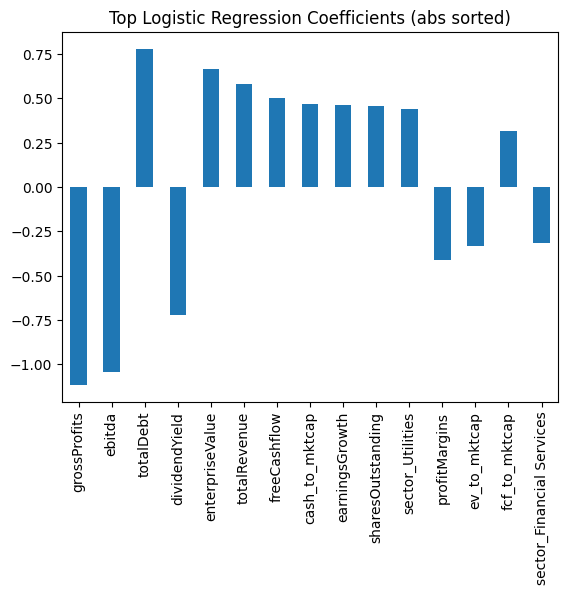

In [52]:

best_model = best["model"]
clf = best_model.named_steps.get("clf", best_model)

if hasattr(clf, "feature_importances_"):
    importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(importances.head(15))
    importances.head(15).plot(kind="bar")
    plt.title(f"Top Feature Importances: {best_name}")
    plt.show()
elif hasattr(clf, "coef_"):
    coefs = pd.Series(clf.coef_[0], index=X.columns).sort_values(key=np.abs, ascending=False)
    display(coefs.head(15))
    coefs.head(15).plot(kind="bar")
    plt.title("Top Logistic Regression Coefficients (abs sorted)")
    plt.show()
else:
    print("No simple feature importance available for this model.")


# Feature Interpretation

The coefficient plot shows which financial variables the Logistic Regression model relies on most when predicting whether a stock will outperform SPY. Positive coefficients increase the likelihood of outperformance, while negative coefficients decrease it.

Several size and valuation-related variables, such as enterprise value, total revenue, and free cash flow, have positive coefficients. This suggests that larger firms with stronger cash-generating ability are more likely to outperform the market in this dataset. Earnings growth and shares outstanding also contribute positively, indicating that growth-related characteristics play an important role in the model’s predictions.

On the other hand, variables related to costs and leverage, such as gross profits, EBITDA, and dividend yield, have negative coefficients. This implies that firms with higher debt levels or those that return more cash to shareholders through dividends are less likely to outperform SPY over the following year, according to the model.

Overall, the results suggest that the model favors companies with strong revenue scale and growth characteristics, while penalizing firms with heavier debt burdens or more conservative capital-return policies.

In [53]:

results_out = OUT_DIR / "model_results.csv"
save_df(results_df, results_out)

model_out = OUT_DIR / "best_model.joblib"
joblib.dump(best_model, model_out)

print("Saved dataset:", processed_path)
print("Saved results :", results_out)
print("Saved model   :", model_out)


Saved dataset: ../data/processed/modeling_dataset.csv
Saved results : ../data/processed/model_results.csv
Saved model   : ../data/processed/best_model.joblib
